In [1]:
import pandas as pd
import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from rectification_utils import *

import open3d as o3d
import laspy
import lazrs
import laszip

from photo_utils import *

## Camera Calibration Parameters

In [2]:
intrinsics = np.array([3040, # number of pixel columns
                       4056, # number of pixel rows
                       1503.0136, # U component of principal point
                       2163.4301, # V component of principal point
                       2330.4972, # U component of focal length
                       2334.0017, # V component of focal length
                       -0.3587, # radial distortion 
                       0.1388, # radial distortion
                       -0.0266, # radial distortion
                       -0.0046, # tangential distortion
                       0.0003 # tangential distortion
                       ])

In [3]:
extrinsics = np.array([712159.597863065, # camera x in world
                       33136.9994153273, # camera y in world
                       3.72446811607855, # camera elev in world
                       1.30039127961854, # azimuth
                       1.02781393967485, # tilt
                       -0.160877893129538 # roll/swing
                       ])

# Grid Generation

## Read in data

In [4]:
file_path = '/Users/ryan/Documents/image_processing/lidar/lidar_data/Job1051007_34077_04_88.laz'
las = laspy.read(file_path)

In [5]:
pts_mask = las.classification == 2 # land classification (1 is unclassified points)
xyz_t = np.vstack([las.x[pts_mask], las.y[pts_mask], las.z[pts_mask]])
building_xyz_m = xyz_t * 0.3048 

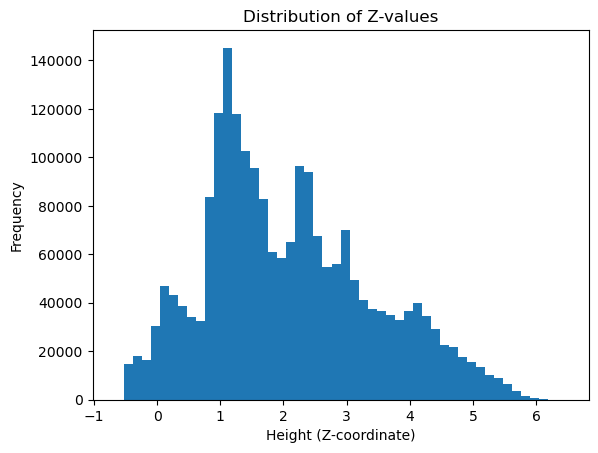

Min height: -0.667512
Max height: 6.473952000000001
Percentiles: [1.109472 1.868424 2.950464]


In [6]:
# Plot the distribution of heights (Z-values)
plt.hist(building_xyz_m[2, :], bins=50)
plt.xlabel('Height (Z-coordinate)')
plt.ylabel('Frequency')
plt.title('Distribution of Z-values')
plt.show()

# Print the min, max, and some percentiles of the height distribution
print(f"Min height: {np.min(building_xyz_m[2, :])}")
print(f"Max height: {np.max(building_xyz_m[2, :])}")
print(f"Percentiles: {np.percentile(building_xyz_m[2, :], [25, 50, 75])}")

In [7]:
point_cloud_df = pd.DataFrame(building_xyz_m.T, columns=['x', 'y', 'z'])

max_x_extent = 712230
min_x_extent = 712160
max_y_extent = 33170
min_y_extent = 33100

# Filter the DataFrame
filtered_df = point_cloud_df[
    (point_cloud_df['x'] >= min_x_extent) & (point_cloud_df['x'] <= max_x_extent) &
    (point_cloud_df['y'] >= min_y_extent) & (point_cloud_df['y'] <= max_y_extent)
]

x = filtered_df['x'].values
y = filtered_df['y'].values
z = filtered_df['z'].values

resolution = 0.01 # meters

In [8]:
pts_array = np.array([x, y, z])
print(pts_array.shape)

(3, 35549)


## Generate and plot grid

In [9]:
# Get the topo colormap from cmocean
cmap = cmocean.cm.topo

# Truncate the colormap to get only the above-land portion
# Assuming "above land" is the upper half of the colormap
above_land_cmap = LinearSegmentedColormap.from_list(
    'above_land_cmap', cmap(np.linspace(0.5, 1, 256))
)

In [10]:
grid_x, grid_y, grid_z = gen_grid(min_x_extent, max_x_extent, min_y_extent, max_y_extent, resolution, pts_array)

Directory to store grids already exists: generated_grids


In [11]:
grid_x = grid_x.T
grid_y = grid_y.T
grid_z = grid_z.T

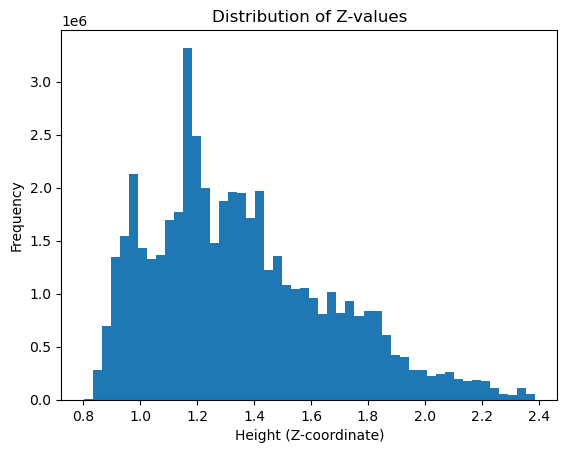

Min height: 0.8019983322209893
Max height: 2.3865504413450687
Percentiles: [1.12599418 1.3041749  1.55125049]
Number of NaN values: 65921


In [12]:
# Plot the distribution of heights (Z-values)
elev_values = grid_z.ravel()

plt.hist(elev_values, bins=50)
plt.xlabel('Height (Z-coordinate)')
plt.ylabel('Frequency')
plt.title('Distribution of Z-values')
plt.show()

# Print the min, max, and some percentiles of the height distribution
print(f"Min height: {np.nanmin(elev_values)}")
print(f"Max height: {np.nanmax(elev_values)}")
print(f"Percentiles: {np.nanpercentile(elev_values, [25, 50, 75])}")

# Count the number of NaN values
nan_count = np.sum(np.isnan(elev_values))
print(f'Number of NaN values: {nan_count}')

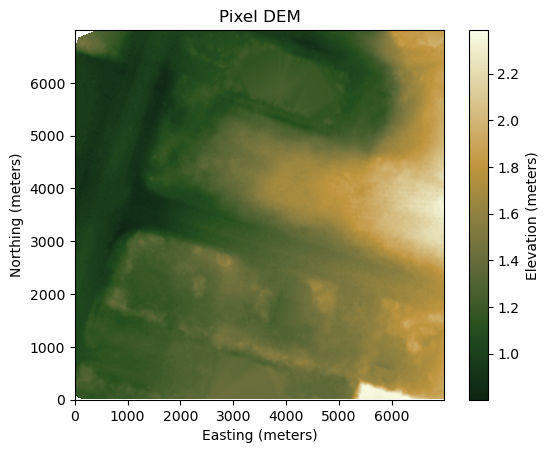

In [13]:
plt.imshow(grid_z, origin='lower', cmap=above_land_cmap)
plt.colorbar(label='Elevation (meters)')
plt.title('Pixel DEM')
plt.xlabel('Easting (meters)')
plt.ylabel('Northing (meters)')

# Save the figure before showing it
# plt.savefig('pixel_DEM_1cm_res_CB_03.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

# Rectifications

In [79]:
zarr_store_path = '/Users/ryan/Documents/image_processing/rectifications/CB_10_02_2023/rect_arrays.zarr'

# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Load the specific array using its name
# ir_array = store['CAM_CB_03_20231002150626_predseg_labels_rectified'][:]
ir_array = store['CAM_CB_03_20231002151825_predseg_labels_rectified'][:]

## Plot segmentation mask

In [80]:
np.unique(ir_array)

array([0, 1, 2, 3, 5], dtype=uint8)

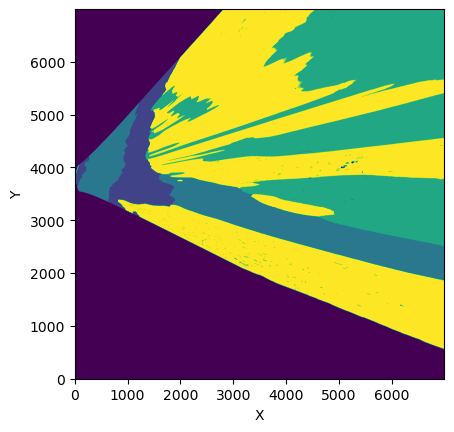

In [81]:
plt.imshow(ir_array)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_labels_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

## Mask to only water and plot

In [82]:
labels_squeezed = ir_array.squeeze()
mask = (labels_squeezed == 1)
masked_elevations = np.where(mask, grid_z, np.nan)  # Use np.nan or another value for masked entries

In [83]:
masked_labels = np.where(ir_array == 1, ir_array, 0)
masked_labels = np.squeeze(masked_labels)

In [84]:
masked_labels.shape

(7000, 7000)

In [85]:
np.unique(masked_labels)

array([0, 1], dtype=uint8)

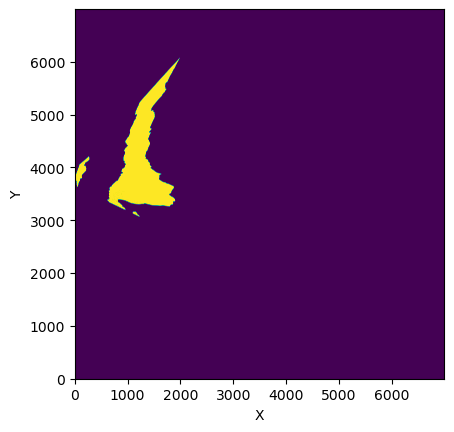

In [86]:
plt.imshow(masked_labels)
plt.gca().invert_yaxis()
plt.xlabel('X')
plt.ylabel('Y')

# plt.savefig('rectified_labels_image.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

plt.show()

## Group ponding

In [87]:
from scipy.ndimage import label
import matplotlib.colors as mcolors
from scipy.ndimage import binary_closing

In [103]:
closed_data = binary_closing(masked_labels, structure=np.ones((3, 3)))

In [104]:
labeled_data, num_features = label(np.nan_to_num(closed_data, nan=0), )  # Convert NaNs to 0 for labeling

In [106]:
min_size = 250  # Minimum size of a pond
unique, counts = np.unique(labeled_data, return_counts=True)
small_ponds = unique[counts < min_size]  # Identify small ponds
labeled_data[np.isin(labeled_data, small_ponds)] = 0  # Remove small ponds

# Reapply the label function to relabel the remaining ponds
labeled_data, num_features = label(labeled_data)

# Count the number of unique non-zero features (ponds)
num_features = np.max(labeled_data)  # The highest label after relabeling is the number of features


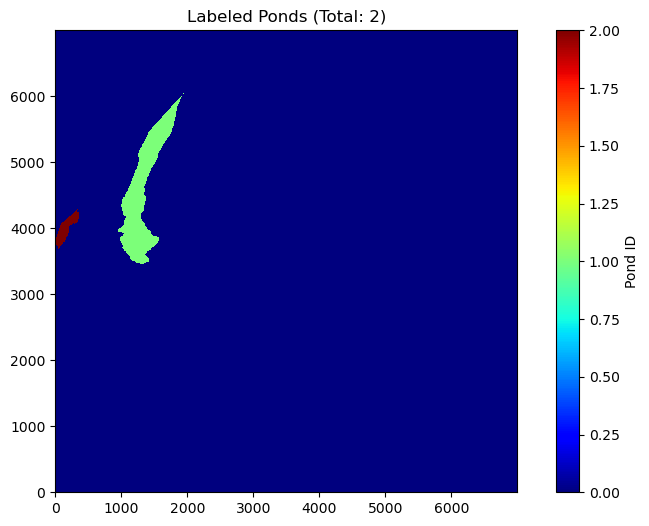

In [111]:
# Plot the labeled data
plt.figure(figsize=(10, 6))
plt.imshow(labeled_data, cmap='jet', interpolation='nearest')
plt.gca().invert_yaxis()
plt.colorbar(label='Pond ID')
plt.title(f'Labeled Ponds (Total: {num_features})')
plt.show()

## Plot folder of groupings to compare

In [ ]:
zarr_store_path = '/Users/ryan/Documents/image_processing/rectifications/CB_10_02_2023/rect_arrays.zarr'

# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Iterate over all the keys (arrays) in the Zarr store
for array_name in store.keys():
    if array_name.endswith('predseg_labels_rectified'):
        print(f"Processing array: {array_name}")
    
        # Load the array using its name
        ir_array = store[array_name][:]

        labels_squeezed = ir_array.squeeze()
        mask = (labels_squeezed == 1)
        masked_elevations = np.where(mask, grid_z, np.nan)  # Use np.nan or another value for masked entries

        masked_labels = np.where(ir_array == 1, ir_array, 0)
        masked_labels = np.squeeze(masked_labels)

        closed_data = binary_closing(masked_labels, structure=np.ones((3, 3)))
    
        labeled_data, num_features = label(closed_data)

        min_size = 500  # Minimum size of a pond
        unique, counts = np.unique(labeled_data, return_counts=True)
        small_ponds = unique[counts < min_size]  # Identify small ponds
        labeled_data[np.isin(labeled_data, small_ponds)] = 0  # Remove small ponds

        # Reapply the label function to relabel the remaining ponds
        labeled_data, num_features = label(labeled_data)

        # Count the number of unique non-zero features (ponds)
        num_features = np.max(labeled_data)  # The highest label after relabeling is the number of features

        # Plot the labeled data
        plt.figure(figsize=(10, 6))
        plt.imshow(labeled_data, cmap='jet', interpolation='nearest')
        plt.gca().invert_yaxis()
        plt.colorbar(label='Pond ID')
        plt.title(f'Labeled Ponds (Total: {num_features})')
        plt.savefig(f'ponding_group_plots/{array_name}.png')
        plt.close()

## Select Contours

In [149]:
from skimage.measure import find_contours
from scipy.spatial import cKDTree

In [150]:
labels_squeezed = ir_array.squeeze()
mask = (labels_squeezed == 1)
masked_elevations = np.where(mask, grid_z, 0)  # Use np.nan or another value for masked entries

In [151]:
# Sample array with labeled ponds (this should be your `labeled_data`)
arr = masked_elevations  # Replace with your masked elevation data
labeled_data = labeled_data  # The output from your previous labeling process

# Step 2: Get the unique pond labels (excluding background)
unique_ponds = np.unique(labeled_data)
unique_ponds = unique_ponds[unique_ponds != 0]  # Exclude background label

# Initialize a dictionary to hold contours for each pond
pond_contours = {}

# Step 3: For each pond, extract contours separately
for pond_id in unique_ponds:
    # Create a binary mask for the current pond
    pond_mask = (labeled_data == pond_id)

    # Replace NaNs with zeros for contour detection
    pond_arr = np.where(pond_mask, arr, 0)

    # Find contours for the pond
    contours = find_contours(pond_arr, level=0.5)
    
    # Store the contours for this pond in the dictionary
    pond_contours[pond_id] = contours

# Step 4: Convert contour coordinates to integer indices and extract values for each pond
contour_pixels_per_pond = {}
contour_values_per_pond = {}

for pond_id, contours in pond_contours.items():
    contour_pixels = []
    contour_values = []
    
    for contour in contours:
        for point in contour:
            y, x = np.round(point).astype(int)
            if 0 <= x < arr.shape[1] and 0 <= y < arr.shape[0]:  # Ensure indices are within bounds
                contour_pixels.append((x, y))
                contour_values.append(arr[y, x])
    
    # Store contour pixels and values for this pond
    contour_pixels_per_pond[pond_id] = np.array(contour_pixels)
    contour_values_per_pond[pond_id] = np.array(contour_values)



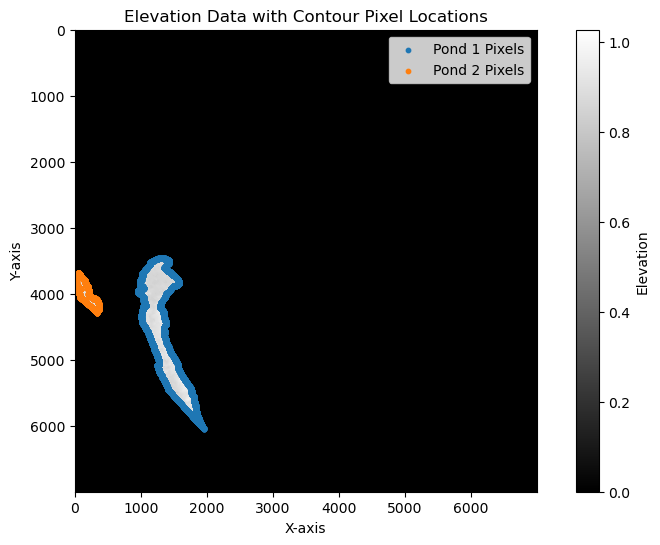

In [154]:
# Step 5: Plot the elevation data and contour pixel locations for each pond
plt.figure(figsize=(10, 6))

# Plot the original array (with NaNs masked out)
plt.imshow(arr, cmap='gray', interpolation='none')
plt.colorbar(label='Elevation')
plt.title("Elevation Data with Contour Pixel Locations")

# Plot contours and contour pixels for each pond
colors = plt.cm.tab10.colors  # Color map for distinct pond colors

for i, (pond_id, contour_pixels) in enumerate(contour_pixels_per_pond.items()):
    # Plot contour pixel locations for each pond
    plt.scatter(contour_pixels[:, 0], contour_pixels[:, 1], s=10, color=colors[i % len(colors)], label=f'Pond {pond_id} Pixels')

# Add legend to indicate pond IDs
plt.legend()
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

## Plot folder of edge pixels for comparison

In [156]:
zarr_store_path = '/Users/ryan/Documents/image_processing/rectifications/CB_10_02_2023/rect_arrays.zarr'

# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Iterate over all the keys (arrays) in the Zarr store
for array_name in store.keys():
    if array_name.endswith('predseg_labels_rectified'):
        print(f"Processing array: {array_name}")
    
        # Load the array using its name
        ir_array = store[array_name][:]

        labels_squeezed = ir_array.squeeze()
        mask = (labels_squeezed == 1)
        masked_elevations = np.where(mask, grid_z, np.nan)  # Use np.nan or another value for masked entries

        masked_labels = np.where(ir_array == 1, ir_array, 0)
        masked_labels = np.squeeze(masked_labels)

        closed_data = binary_closing(masked_labels, structure=np.ones((3, 3)))
    
        labeled_data, num_features = label(closed_data)

        min_size = 500  # Minimum size of a pond
        unique, counts = np.unique(labeled_data, return_counts=True)
        small_ponds = unique[counts < min_size]  # Identify small ponds
        labeled_data[np.isin(labeled_data, small_ponds)] = 0  # Remove small ponds

        # Reapply the label function to relabel the remaining ponds
        labeled_data, num_features = label(labeled_data)

        # Count the number of unique non-zero features (ponds)
        num_features = np.max(labeled_data)  # The highest label after relabeling is the number of features

        labels_squeezed = ir_array.squeeze()
        mask = (labels_squeezed == 1)
        masked_elevations = np.where(mask, grid_z, 0)  # Use np.nan or another value for masked entries


        # Sample array with labeled ponds (this should be your `labeled_data`)
        arr = masked_elevations  # Replace with your masked elevation data
        labeled_data = labeled_data  # The output from your previous labeling process

        # Step 2: Get the unique pond labels (excluding background)
        unique_ponds = np.unique(labeled_data)
        unique_ponds = unique_ponds[unique_ponds != 0]  # Exclude background label

        # Initialize a dictionary to hold contours for each pond
        pond_contours = {}

        # Step 3: For each pond, extract contours separately
        for pond_id in unique_ponds:
            # Create a binary mask for the current pond
            pond_mask = (labeled_data == pond_id)

            # Replace NaNs with zeros for contour detection
            pond_arr = np.where(pond_mask, arr, 0)

            # Find contours for the pond
            contours = find_contours(pond_arr, level=0.5)
    
            # Store the contours for this pond in the dictionary
            pond_contours[pond_id] = contours

        # Step 4: Convert contour coordinates to integer indices and extract values for each pond
        contour_pixels_per_pond = {}
        contour_values_per_pond = {}

        for pond_id, contours in pond_contours.items():
            contour_pixels = []
            contour_values = []
    
            for contour in contours:
                for point in contour:
                    y, x = np.round(point).astype(int)
                    if 0 <= x < arr.shape[1] and 0 <= y < arr.shape[0]:  # Ensure indices are within bounds
                        contour_pixels.append((x, y))
                        contour_values.append(arr[y, x])
    
            # Store contour pixels and values for this pond
            contour_pixels_per_pond[pond_id] = np.array(contour_pixels)
            contour_values_per_pond[pond_id] = np.array(contour_values)

        # Step 5: Plot the elevation data and contour pixel locations for each pond
        plt.figure(figsize=(10, 6))

        # Plot the original array (with NaNs masked out)
        plt.imshow(arr, cmap='gray', interpolation='none')
        plt.colorbar(label='Elevation')
        plt.title("Elevation Data with Contour Pixel Locations")

        # Plot contours and contour pixels for each pond
        colors = plt.cm.tab10.colors  # Color map for distinct pond colors

        for i, (pond_id, contour_pixels) in enumerate(contour_pixels_per_pond.items()):
            # Plot contour pixel locations for each pond
            plt.scatter(contour_pixels[:, 0], contour_pixels[:, 1], s=10, color=colors[i % len(colors)], label=f'Pond {pond_id} Pixels')

        # Add legend to indicate pond IDs
        plt.legend()
        plt.xlabel("X-axis")
        plt.ylabel("Y-axis")
        plt.savefig(f'ponding_edge_pixels/{array_name}.png')
        plt.close()

        

Processing array: CAM_CB_03_20231002140025_predseg_labels_rectified
Processing array: CAM_CB_03_20231002140625_predseg_labels_rectified
Processing array: CAM_CB_03_20231002141225_predseg_labels_rectified
Processing array: CAM_CB_03_20231002141825_predseg_labels_rectified
Processing array: CAM_CB_03_20231002142425_predseg_labels_rectified
Processing array: CAM_CB_03_20231002143025_predseg_labels_rectified
Processing array: CAM_CB_03_20231002143625_predseg_labels_rectified
Processing array: CAM_CB_03_20231002144226_predseg_labels_rectified
Processing array: CAM_CB_03_20231002144825_predseg_labels_rectified
Processing array: CAM_CB_03_20231002145425_predseg_labels_rectified
Processing array: CAM_CB_03_20231002150025_predseg_labels_rectified
Processing array: CAM_CB_03_20231002150626_predseg_labels_rectified
Processing array: CAM_CB_03_20231002151225_predseg_labels_rectified
Processing array: CAM_CB_03_20231002151825_predseg_labels_rectified
Processing array: CAM_CB_03_20231002152425_preds

## Depth Mapping with updated edge pixel algorithm

In [160]:
contour_values_per_pond[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [184]:
# Initialize a dictionary to hold contours for each pond
pond_depths = {}

# Step 3: For each pond, extract contours separately
for pond_id in unique_ponds:
    # Create a binary mask for the current pond
    pond_mask = (labeled_data == pond_id)
    # pond_squeezed = pond_mask.squeeze()
    # mask = (labels_squeezed == pond_id)
    masked_elevations = np.where(pond_mask, grid_z, np.nan)

    max_elevation = np.nanmedian(contour_values_per_pond[pond_id])

    depth_map = masked_elevations - max_elevation
    depth_map[depth_map > 0] = 0
    depth_map = np.abs(depth_map)

    # Store the contours for this pond in the dictionary
    pond_depths[pond_id] = depth_map

combined = pond_depths[1]

# Loop over the remaining arrays, starting from key 2
for i in range(2, len(pond_depths) + 1):
    combined = np.where(np.isnan(combined), pond_depths[i], np.where(np.isnan(pond_depths[i]), combined, combined + pond_depths[i]))


In [185]:
zarr_store_path = '/Users/ryan/Documents/image_processing/rectifications/CB_10_02_2023/rect_arrays.zarr'

# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Load the specific array using its name
background = store['CAM_CB_03_20231002150626_rectified'][:]
grayscale_image = np.dot(background[...,:3], [0.2989, 0.5870, 0.1140])

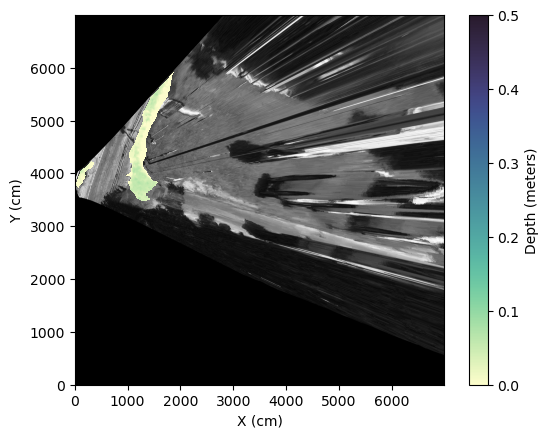

In [187]:
# Plot the image
plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

# Overlay the depth map
im = plt.imshow(combined, cmap=cmocean.cm.deep, vmin=0, vmax=0.5)  # Adjust alpha for transparency
# plt.scatter(virtual_sensor_locs[0][0], virtual_sensor_locs[0][1], color=sensor_1_color, s=50, marker='v')
# plt.scatter(virtual_sensor_locs[1][0], virtual_sensor_locs[1][1], color=sensor_2_color, s=50, marker='s')
# plt.scatter(virtual_sensor_locs[2][0], virtual_sensor_locs[2][1], color=sensor_3_color, s=50, marker='d')
# plt.scatter(max_indices[1], max_indices[0], c='red', s=10, marker='o')

# Add a colorbar for the depth map
cbar = plt.colorbar(im, label='Depth')
cbar.set_label('Depth (meters)')

plt.gca().invert_yaxis()
plt.xlabel('X (cm)')
plt.ylabel('Y (cm)')

# Save the figure
# plt.savefig('rectified_image_with_depth.png', bbox_inches='tight', pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

## Plot folder of depth maps with new method for comparison

In [190]:
zarr_store_path = '/Users/ryan/Documents/image_processing/rectifications/CB_10_02_2023/rect_arrays.zarr'

# Open the Zarr store in read mode
store = zarr.open_group(zarr_store_path, mode='r')

# Iterate over all the keys (arrays) in the Zarr store
for array_name in store.keys():
    if array_name.endswith('predseg_labels_rectified'):
        print(f"Processing array: {array_name}")
    
        # Load the array using its name
        ir_array = store[array_name][:]

        labels_squeezed = ir_array.squeeze()
        mask = (labels_squeezed == 1)
        masked_elevations = np.where(mask, grid_z, np.nan)  # Use np.nan or another value for masked entries

        masked_labels = np.where(ir_array == 1, ir_array, 0)
        masked_labels = np.squeeze(masked_labels)

        closed_data = binary_closing(masked_labels, structure=np.ones((3, 3)))
    
        labeled_data, num_features = label(closed_data)

        min_size = 500  # Minimum size of a pond
        unique, counts = np.unique(labeled_data, return_counts=True)
        small_ponds = unique[counts < min_size]  # Identify small ponds
        labeled_data[np.isin(labeled_data, small_ponds)] = 0  # Remove small ponds

        # Reapply the label function to relabel the remaining ponds
        labeled_data, num_features = label(labeled_data)

        # Count the number of unique non-zero features (ponds)
        num_features = np.max(labeled_data)  # The highest label after relabeling is the number of features

        labels_squeezed = ir_array.squeeze()
        mask = (labels_squeezed == 1)
        masked_elevations = np.where(mask, grid_z, 0)  # Use np.nan or another value for masked entries


        # Sample array with labeled ponds (this should be your `labeled_data`)
        arr = masked_elevations  # Replace with your masked elevation data
        labeled_data = labeled_data  # The output from your previous labeling process

        # Step 2: Get the unique pond labels (excluding background)
        unique_ponds = np.unique(labeled_data)
        unique_ponds = unique_ponds[unique_ponds != 0]  # Exclude background label

        # Initialize a dictionary to hold contours for each pond
        pond_contours = {}

        # Step 3: For each pond, extract contours separately
        for pond_id in unique_ponds:
            # Create a binary mask for the current pond
            pond_mask = (labeled_data == pond_id)

            # Replace NaNs with zeros for contour detection
            pond_arr = np.where(pond_mask, arr, 0)

            # Find contours for the pond
            contours = find_contours(pond_arr, level=0.5)
    
            # Store the contours for this pond in the dictionary
            pond_contours[pond_id] = contours

        # Step 4: Convert contour coordinates to integer indices and extract values for each pond
        contour_pixels_per_pond = {}
        contour_values_per_pond = {}

        for pond_id, contours in pond_contours.items():
            contour_pixels = []
            contour_values = []
    
            for contour in contours:
                for point in contour:
                    y, x = np.round(point).astype(int)
                    if 0 <= x < arr.shape[1] and 0 <= y < arr.shape[0]:  # Ensure indices are within bounds
                        contour_pixels.append((x, y))
                        contour_values.append(arr[y, x])
    
            # Store contour pixels and values for this pond
            contour_pixels_per_pond[pond_id] = np.array(contour_pixels)
            contour_values_per_pond[pond_id] = np.array(contour_values)

        # Initialize a dictionary to hold contours for each pond
        pond_depths = {}

        # Step 3: For each pond, extract contours separately
        for pond_id in unique_ponds:
            # Create a binary mask for the current pond
            pond_mask = (labeled_data == pond_id)
            # pond_squeezed = pond_mask.squeeze()
            # mask = (labels_squeezed == pond_id)
            masked_elevations = np.where(pond_mask, grid_z, np.nan)

            max_elevation = np.nanmedian(contour_values_per_pond[pond_id])

            depth_map = masked_elevations - max_elevation
            depth_map[depth_map > 0] = 0
            depth_map = np.abs(depth_map)

            # Store the contours for this pond in the dictionary
            pond_depths[pond_id] = depth_map

        combined_depth_map = pond_depths[1]

        # Loop over the remaining arrays, starting from key 2
        for i in range(2, len(pond_depths) + 1):
            combined_depth_map = np.where(np.isnan(combined_depth_map), pond_depths[i], np.where(np.isnan(pond_depths[i]), combined_depth_map, combined_depth_map + pond_depths[i]))

        # Plot the image
        plt.imshow(grayscale_image, cmap='gray')  # Assuming ir_array is your grayscale image

        # Overlay the depth map
        im = plt.imshow(combined_depth_map, cmap=cmocean.cm.deep, vmin=0, vmax=0.5)  # Adjust alpha for transparency


        # Add a colorbar for the depth map
        cbar = plt.colorbar(im, label='Depth')
        cbar.set_label('Depth (meters)')

        plt.gca().invert_yaxis()
        plt.xlabel('X (cm)')
        plt.ylabel('Y (cm)')

        # Save the figure
        plt.savefig(f'ponding_method_depth_maps/{array_name}.png')

        plt.close()
        

Processing array: CAM_CB_03_20231002140025_predseg_labels_rectified
Processing array: CAM_CB_03_20231002140625_predseg_labels_rectified
Processing array: CAM_CB_03_20231002141225_predseg_labels_rectified
Processing array: CAM_CB_03_20231002141825_predseg_labels_rectified
Processing array: CAM_CB_03_20231002142425_predseg_labels_rectified
Processing array: CAM_CB_03_20231002143025_predseg_labels_rectified
Processing array: CAM_CB_03_20231002143625_predseg_labels_rectified
Processing array: CAM_CB_03_20231002144226_predseg_labels_rectified
Processing array: CAM_CB_03_20231002144825_predseg_labels_rectified
Processing array: CAM_CB_03_20231002145425_predseg_labels_rectified
Processing array: CAM_CB_03_20231002150025_predseg_labels_rectified
Processing array: CAM_CB_03_20231002150626_predseg_labels_rectified
Processing array: CAM_CB_03_20231002151225_predseg_labels_rectified
Processing array: CAM_CB_03_20231002151825_predseg_labels_rectified
Processing array: CAM_CB_03_20231002152425_preds